In [1]:
import torch

/lustre/hpc/pheno/inar/mambaforge/envs/torch39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
from scipy.stats import entropy

import numpy as np
from matplotlib.colors import LogNorm

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [4]:
model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1", 
                                          torch_dtype=torch.float16,
                                          device_map={"": 1})
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")


Loading checkpoint shards: 100%|██████████| 2/2 [00:16<00:00,  8.46s/it]


In [5]:
from transformers import pipeline, TextStreamer

In [7]:
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
prompt = "It's prequel time again. In December, we'll get to "
generated = pipe(prompt, streamer=TextStreamer(tokenizer), max_new_tokens=128)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


It's prequel time again. In December, we'll get to 1984's "The Terminator," and in January, we'll get to 1989's "Terminator 2: Judgment Day."

The first film, which was directed by James Cameron, is about a cyborg assassin from the future who is sent back in time to kill Sarah Connor (Linda Hamilton), the mother of the future leader of the human resistance against the machines. The second film, which was also directed by Cameron, is about the same cyborg assassin, who is sent back in time to protect Sarah's son, John Connor (


Entropy: 7.660931410292432


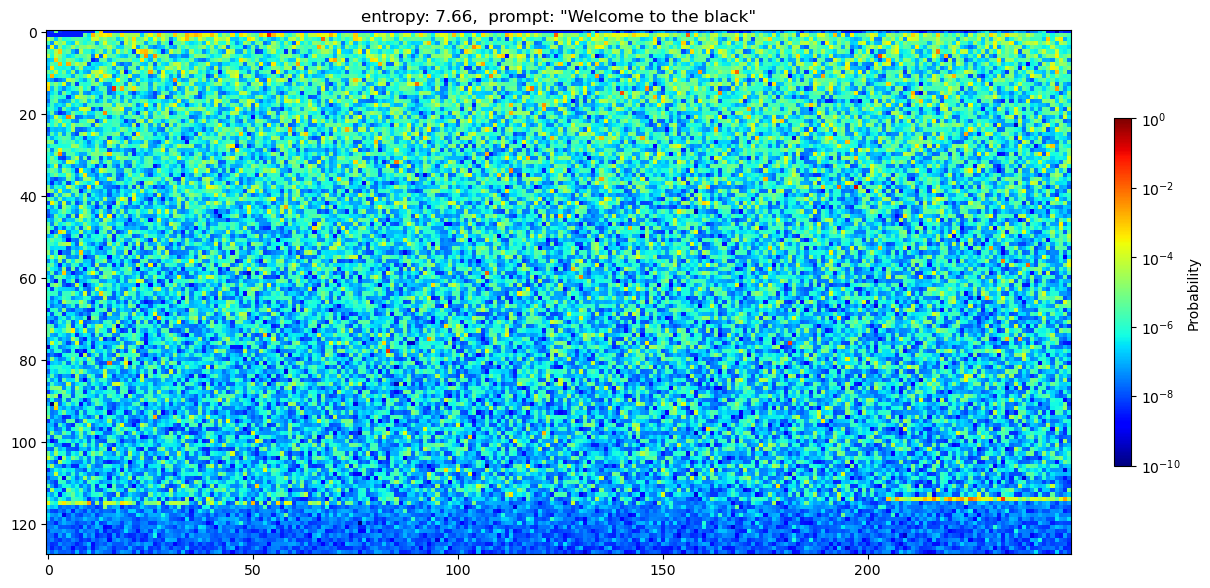

In [9]:
text = "Welcome to the black"

inputs = tokenizer(text, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits[:, -1, :]  # Taking the logits corresponding to the last token in input
    probabilities = torch.nn.functional.softmax(logits, dim=-1)

probabilities_np = probabilities.numpy().flatten()
# Padding zeros to fit the grid size
probabilities_np = np.concatenate((probabilities_np, np.zeros(250 * 128 - tokenizer.vocab_size)))

# Reshape the array
reshaped_probs = probabilities_np.reshape((128, 250))

# Create the heatmap
plt.figure(figsize=(14, 10))
im = plt.imshow(reshaped_probs, cmap="jet", interpolation="nearest", norm=LogNorm(vmin=1e-10, vmax=1))

# Create the colorbar
cbar = plt.colorbar(im, label="Probability", fraction=0.016, pad=0.04)
cbar.ax.set_yscale('log')

# plt.title("Heatmap of Output Probabilities (Log Scale)")

# Using scipy.stats.entropy function, and converting tensor to numpy array
output_entropy = entropy(probabilities.numpy().flatten(), base=2)
print(f"Entropy: {output_entropy}")


plt.title(f'entropy: {output_entropy:.2f},  prompt: "{text}"')
plt.show()


In [10]:
# Define a text prompt
prompt = "Welcome to the black"
# prompt = "Wikipedia is a free-content online"
# Tokenize the prompt and generate output IDs and logits
input_ids = tokenizer.encode(prompt, return_tensors="pt")
with torch.no_grad():
    outputs = model(input_ids)
    logits = outputs.logits

# Get logits corresponding to the last token (prediction)
last_logits = logits[0, -1, :]

# Apply softmax to get probabilities
import torch.nn.functional as F
probabilities = F.softmax(last_logits, dim=-1)

# Optionally, you can sort and get top-k tokens
sorted_indices = torch.argsort(probabilities, descending=True)
top_k = 10
for i in range(top_k):
    token_id = sorted_indices[i].item()
    token = tokenizer.decode([token_id])
    probability = probabilities[token_id].item()
    print(f"Token: {token}, Probability: {probability}")

Token: hole, Probability: 0.1545012891292572
Token: and, Probability: 0.06291376799345016
Token: board, Probability: 0.05015922337770462
Token: sheep, Probability: 0.038458410650491714
Token: -, Probability: 0.03420561924576759
Token: jack, Probability: 0.026432054117321968
Token: list, Probability: 0.02492780238389969
Token: box, Probability: 0.024830617010593414
Token: belt, Probability: 0.013239054940640926
Token: out, Probability: 0.01288195513188839


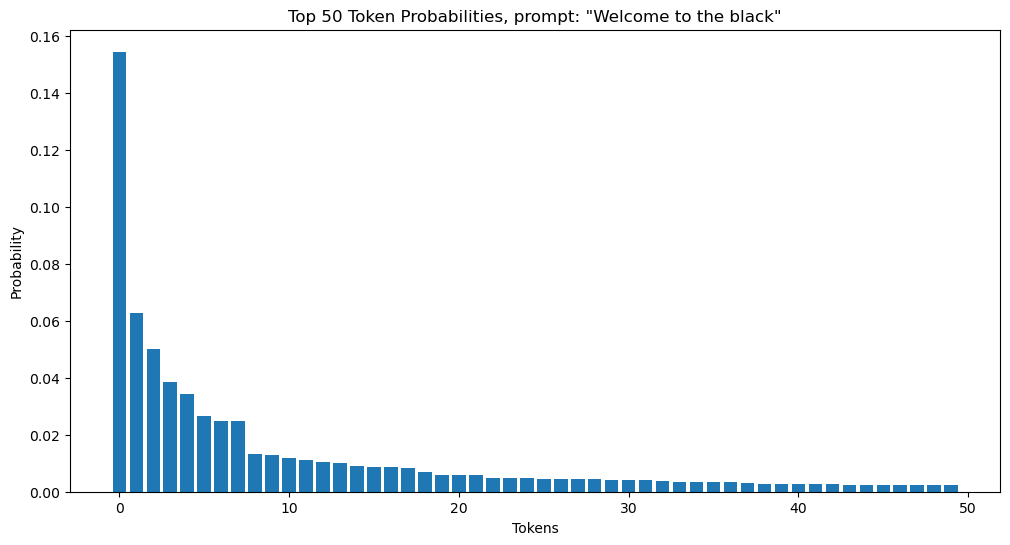

In [11]:
top_n = 50
top_probs, top_indices = torch.topk(probabilities, top_n)

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(range(top_n), top_probs)
plt.xlabel('Tokens')
plt.ylabel('Probability')
plt.title(f'Top 50 Token Probabilities, prompt: "{prompt}"')
plt.show()

In [12]:

def generate_and_record_probs(tokenizer, model, prompt, num_generate=5, print_tokens=False,  temperature=1.0, top_k=None):
    # Initialize list to store all top 50 probabilities for each token
    all_top_probs = []
    
    # Convert prompt to input_ids
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    
    for i in range(num_generate):
        with torch.no_grad():
            outputs = model(input_ids)
            logits = outputs.logits
            last_logits = logits[0, -1, :]
            probabilities = F.softmax(last_logits, dim=-1)
            
            # Store the top 50 probabilities
            top_probs, top_indices = torch.topk(probabilities, 50)
            all_top_probs.append(top_probs)
            
            # Get most probable token and its probability
            most_probable_token_id = top_indices[0].item()
            most_probable_token = tokenizer.decode([most_probable_token_id])
            most_probable_token_prob = top_probs[0].item()
            
            # Generate the next token and append to input_ids
            logits = last_logits / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[ [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)

            next_token = torch.multinomial(probs, 1)
            next_token_id = next_token.item()
            next_token_str = tokenizer.decode([next_token_id])
            input_ids = torch.cat([input_ids, next_token.unsqueeze(0)], dim=1)
            
            if print_tokens:
                # print(f"Top: {most_probable_token}, p: {most_probable_token_prob:.4f}, selected: {next_token_str}, p: {probabilities[next_token_id].item():.4f}")
                field_width = 10

                print(f"i = {i:<{3}} Top: {most_probable_token:<{field_width}} p: {most_probable_token_prob:.4f} "
                    f"Selected: {next_token_str:<{field_width}} p: {probabilities[next_token_id].item():.4f}")

    generated_text = tokenizer.decode(input_ids.squeeze(), skip_special_tokens=True)         
    return all_top_probs, generated_text




In [13]:
# Example usage
prompt = "Welcome to the black"
all_top_probs, generated_text = generate_and_record_probs(tokenizer, model, prompt,num_generate = 20, print_tokens=True, temperature=1.0)
print(generated_text)



i = 0   Top: hole       p: 0.1545 Selected: out        p: 0.0129
i = 1   Top: .          p: 0.2108 Selected: period     p: 0.0129
i = 2   Top: .          p: 0.2573 Selected: in         p: 0.0239
i = 3   Top: the        p: 0.3336 Selected: an         p: 0.0011
i = 4   Top: election   p: 0.3059 Selected: of         p: 0.0003
i = 5   Top: t          p: 0.9028 Selected: t          p: 0.9028
i = 6   Top: -          p: 0.6929 Selected: -          p: 0.6929
i = 7   Top: for        p: 0.0977 Selected: used       p: 0.0072
i = 8   Top: phrase     p: 0.2247 Selected: term       p: 0.0591
i = 9   Top: in         p: 0.3520 Selected: in         p: 0.3520
i = 10  Top: the        p: 0.4432 Selected: markets    p: 0.0015
i = 11  Top: .          p: 0.2974 Selected: for        p: 0.0181
i = 12  Top: the        p: 0.1699 Selected: dark       p: 0.0004
i = 13  Top: pool       p: 0.3714 Selected: pool       p: 0.3714
i = 14  Top: s          p: 0.8359 Selected: s          p: 0.8359
i = 15  Top: .          p

/tmp/ipykernel_129742/3697905157.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', len(all_top_probs))


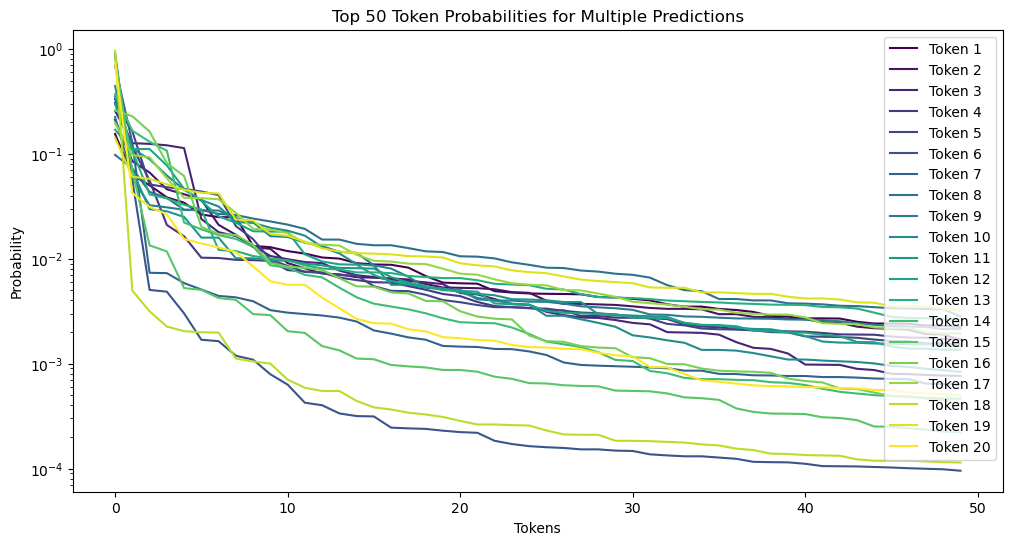

In [14]:
import matplotlib.cm as cm

# Plotting
plt.figure(figsize=(12, 6))

# Create a colormap
colormap = cm.get_cmap('viridis', len(all_top_probs))

for i, top_probs in enumerate(all_top_probs):
    color = colormap(i)
    plt.plot(range(50), top_probs.numpy(), label=f'Token {i+1}', color=color)

plt.xlabel('Tokens')
plt.ylabel('Probability')
plt.title('Top 50 Token Probabilities for Multiple Predictions')
plt.legend()
# plt.colorbar(cm.ScalarMappable(cmap=colormap), label='Token Index')

plt.yscale('log')

plt.show()
